<a href="https://colab.research.google.com/github/DylanMontoya/NLP_algebra_linear/blob/main/word_embedding_svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Word Embedding with Singular Values Descomposition (SVD)**
---

El **Word Embedding** es una técnica de Procesamiento de Lenguaje Natural que busca representar las palabras de un texto en un espacio vectorial, de tal forma que se puedan analizar y comparar utilizando herramientas matemáticas. Esta representación de las palabras permite entender la semántica y el significado que estas tienen en el contexto del texto en el que aparecen [1].

Existen diversas técnicas para realizar el **Word Embedding**, una de las más populares es el **Singular Value Decomposition (SVD)**. SVD es una técnica de algebra lineal que permite descomponer una matriz en sus componentes fundamentales. En el contexto del Word Embedding, se utiliza para descomponer una matriz que contiene información sobre la co-ocurrencia de palabras en un corpus de texto [2].

Al utilizar SVD en una matriz de co-ocurrencia, se obtienen vectores numéricos que representan a cada palabra en el corpus. Estos vectores, también conocidos como embeddings, pueden ser utilizados en diversas aplicaciones de Procesamiento de Lenguaje Natural, tales como la clasificación de texto, la búsqueda de información y la generación de texto. Además, estos vectores pueden ser utilizados para medir la similitud entre palabras y para descubrir patrones y relaciones semánticas entre ellas.


## **Origen de la base de datos**
El corpus utilizado para este trabajo consiste en Historias Clínicas Electrónicas relacionadas con ginecología, las cuales fueron proporcionadas por la clínica UPB de Medellín. Para llevar a cabo este proyecto, se aplicó un proceso de Extracción, Transformación y Carga de datos (ETL, por sus siglas en inglés), con el objetivo de obtener las notas de egreso, que son aquellas que indican el estado de salida de las pacientes en una cita médica. 

A partir de estas notas de egreso, se seleccionaron 100 registros clínicos, los cuales posteriormente fueron etiquetados manualmente utilizando INCEpTION. Una vez completado este proceso, se busca realizar Procesamiento de Lenguaje Natural (PLN) mediante metodos basicos y un poco de información teorica del algebra lineal. Esto con el fin de obtener información semantica del corpus clínico a partir de la representaciones vectoriales de las palabras.

Por ultimo, cabe mencionar que el archivo para este trabajo no es de uso compartido debido a las politicas de ...


## **Procesamiento de texto**
---
En el siguiente paso, se carga el archivo (pickle) que contiene los 100 registros clínicos en formato diccionario de diccionario. Organizado así: `keys: sentences y labels`. Ya se encuentra tokenizado por sentencias.

Posteriormente se eliminan los caracteres no relevantes y palabras vacías. Además, se realiza el análisis de los skipgrams y sus frecuencias con el objetivo de construir la matriz de co-ocurrencia y calcular el índice de Información Mutua Puntual (PMI, por sus siglas en inglés).

In [1]:
import pickle
from google.colab import files
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer, LineTokenizer
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD # Se puede hacer con otras librerias
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Carga de archivo pickle**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# uploaded = files.upload()
# with open('data_hc.pickle', 'rb') as file:
#   data_hc = pickle.load(file)
ruta_archivo = '/content/drive/MyDrive/Colab Notebooks/Tratamiento Matematico/data_hc.pickle'
with open(ruta_archivo, 'rb') as archivo:
    data_hc = pickle.load(archivo)

**Remover palabras y etiquetas que no son de interes para este proyecto**

In [4]:
def remove_labels(data):
  """Remueve las etiquetas 'O' y 'Atributo' debido a que no son de interes"""
  new_data = {'tokens': [], 'labels': []}
  for name, data in data.items():
    for token, label in zip(data['sentence'], data['labels']):
        if label != 'O' and label != 'B-Atributo' and label != 'I-Atributo':
            new_data['tokens'].append(token)
            new_data['labels'].append(label)
  
  return new_data

**Procesamiento del corpus, skipgrams y frecuencia de repetición**

In [5]:
def text_process():
  # Aplico la funcion a cada elemento del diccionario
  processed_data = remove_labels(data_hc)

  stop_words = set(stopwords.words('spanish'))
  
  tokens, labels = [], []
  
  for token, label in zip(processed_data['tokens'], processed_data['labels']):
    token_lower = token.lower()
    if token_lower not in stop_words and token_lower.isalpha():
      tokens.append(token.lower())
      labels.append(label)
  
  uniq_tokens = list(set(tokens))

  token_to_idx = { token: i for i, token in enumerate(uniq_tokens) }

  # Creación de skipgrams y conteo de frecuencias
  # Para n tamaño de ventana y k tamaño de salto
  skip_grams = nltk.skipgrams(tokens, n=2, k=2)
  freq_dict = nltk.FreqDist(skip_grams)
  # freq_dict = dict(freq.items())

  print(tokens[0:20])
  print(labels[0:20]) 
  print('Numero de tokens:', len(tokens), '\n')
  # print(freq.most_common())
  # print('Numero de skipgrams generados:', freq.N())
  # print(freq_dict.most_common())
  print('Numero de skipgrams:', len(freq_dict))
  return tokens, labels, freq_dict, token_to_idx

## **Probabilidades marginales y conjuntas**
$$p(w_{i}) = \frac{N(w_{i})}{\sum_{k}N(w_{k})}$$

La **probabilidad marginal** de una palabra $p(w_{i})$ dentro de un corpus de texto es simplemente el número de veces que aparece la palabra $N(w_{i})$ dividido por el número total de apariciones de palabras en el corpus $\sum_{k}N(w_{k})$




La **probabilidad conjunta** de la palabra $w_{i}$ y otra palabra $w_{j}$, $j\neq i$ es simplemente el número de veces que las palabras co-ocurren $N(w_{i}, w_{j})$ dividido por el número total de palabras:

$$p(w_{i}, w_{j}) = \frac{N(w_{i}, w_{j})}{\sum_{k}N(w_{k})}$$

En este caso $N(w_{i}, w_{j})$ representa la frecuencia de bigrams, es decir, es el recuento del número de veces que una palabra y su siguiente palabra ocurren juntas en el corpus.

**Matriz de co-ocurrencia mediante la frecuancia de skipgrams**

In [6]:
def skipgram_frequency_matrix():
  
  tokens, labels, freq_dict, token_to_idx = text_process()

  # Creación de la matriz sparse de co-ocurrencia
  rows, cols, data = [], [], []

  for skipgram, freq in freq_dict.items():
      if skipgram[0] in token_to_idx and skipgram[1] in token_to_idx:
          rows.append(token_to_idx[skipgram[0]])
          cols.append(token_to_idx[skipgram[1]])
          data.append(freq)

  Y_coo = coo_matrix((data, (rows, cols))).toarray() # , shape=(len(token_to_idx), len(token_to_idx))
  
  return Y_coo, token_to_idx, tokens, labels

## **Informacion Mutua Puntual (PMI)**

Dadas las probabilidades conjuntas $p(w_{i})$ y $p(w_{i}, w_{j})$, podemos calcular algunas cantidades poderosas de teoría de la información.

$$PMI(w_{i}, w_{j}) = log \frac{p(w_{i}, w_{j})}{p(w_{i})p(w_{j})}$$

Esto nos permite calcular asociasiones entre palabras en un corpus. Cada fila de la matriz proporciona la cantidad de información compartida entre una palabra y todas las demás palabras en el corpus. Intuitivamente, la matriz PMI representa el nivel de asociación entre dos palabras. Si las dos palabras son independientes, es decir, no están asociadas, entonces el valor de PMI es cero.

**Matriz PMI a partir de la matriz de co-ocurrencia**

In [7]:
def word_matrix():
  
    Y_coo, token_to_idx, tokens, labels = skipgram_frequency_matrix()
    # Calcula la suma total de elementos en la matriz de co-ocurrencia
    sum_total = Y_coo.sum()

    # Agrega una constante k a todos los elementos de la matriz de co-ocurrencia
    k = 1
    Y_coo_smoothed = Y_coo + k

    # Calcula la matriz de probabilidades conjuntas
    P_joint = Y_coo_smoothed / sum_total

    # Calcula las distribuciones marginales de filas y columnas
    P_row = np.array(Y_coo_smoothed.sum(axis=1)).flatten() / sum_total
    P_col = np.array(Y_coo_smoothed.sum(axis=0)).flatten() / sum_total

    # Calcula la matriz de probabilidades marginales
    P_marginal = np.outer(P_row, P_col)

    # Calcula la matriz de PMI
    pmi = np.log2(P_joint / P_marginal)

    # Crea la matriz sparse de PMI
    Y_pmi = coo_matrix(pmi).toarray()

    return Y_coo, Y_pmi, token_to_idx, tokens, labels

In [8]:
Y_coo, Y_pmi, token_to_idx, tokens, labels = word_matrix()

['desgarro', 'valoracion', 'ambulatoria', 'piso', 'pelvico', 'estable', 'hemodinamicamente', 'pa', 'afebril', 'taquicardia', 'mamas', 'secretantes', 'utero', 'involucion', 'uterina', 'sangrado', 'vaginal', 'serologia', 'infecciosa', 'negativa']
['B-Signo o síntoma', 'B-Procedimiento', 'I-Procedimiento', 'B-Anatomía', 'I-Anatomía', 'B-Signo o síntoma', 'I-Signo o síntoma', 'B-Signo o síntoma', 'B-Signo o síntoma', 'B-Signo o síntoma', 'B-Signo o síntoma', 'I-Signo o síntoma', 'B-Anatomía', 'B-Signo o síntoma', 'I-Signo o síntoma', 'B-Signo o síntoma', 'I-Signo o síntoma', 'B-Procedimiento', 'I-Procedimiento', 'B-Negación']
Numero de tokens: 5911 

Numero de skipgrams: 10829


In [9]:
# Para validar si hay valores diferente de cero en la matriz
print('Hay valores diferente de cero en la matriz Co-ocurrencia', np.any(np.not_equal(Y_coo, 0)), 'y Tamaño de la matriz:', Y_coo.shape)
print(Y_coo)

Hay valores diferente de cero en la matriz Co-ocurrencia True y Tamaño de la matriz: (1189, 1189)
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [10]:
# Para validar si hay valores diferente de infinito en la matriz
print('Hay valores infinitos en la matriz PMI:', np.any(np.isinf(Y_pmi)), 'y Tamaño de la matriz:', Y_pmi.shape)
print(Y_pmi)

Hay valores infinitos en la matriz PMI: False y Tamaño de la matriz: (1189, 1189)
[[-6.32467626 -6.36407377 -6.32830264 ... -6.32467626 -6.35343525
  -6.33552817]
 [-6.36407377 -5.40347128 -6.36770015 ... -6.36407377 -6.39283276
  -6.37492569]
 [-6.32830264 -6.36770015 -6.33192902 ... -6.32830264 -6.35706163
  -6.33915455]
 ...
 [-6.32467626 -6.36407377 -6.32830264 ... -6.32467626 -6.35343525
  -6.33552817]
 [-6.35343525 -6.39283276 -6.35706163 ... -6.35343525 -6.38219424
  -6.36428716]
 [-6.33552817 -6.37492569 -6.33915455 ... -6.33552817 -6.36428716
  -6.34638009]]


## **Descomposición de Valores Singulares para Word Embedding**


La **Descomposición en Valores Singulares** (SVD, por sus siglas en inglés) es una técnica utilizada para la representación vectorial de palabras en el procesamiento del lenguaje natural. SVD permite reducir la dimensionalidad de una matriz de co-ocurrencia o matriz de PMI, capturando la información más relevante y representativa de las palabras [3].
$$A = U S V^T$$

---

El proceso de uso de SVD para la representación vectorial de palabras implica los siguientes pasos:



1. Construcción de la matriz de co-ocurrencia o matriz de PMI: Se crea una matriz que representa las frecuencias de co-ocurrencia o las medidas de PMI entre las palabras del corpus. Cada fila de la matriz representa una palabra y cada columna representa un contexto o palabra vecina.

2. Aplicación de la descomposición en valores singulares: Se realiza la descomposición SVD de la matriz de co-ocurrencia o matriz de PMI. Esta descomposición factoriza la matriz en tres componentes: $U$, $S$ y $V^T$.

3. Selección de los componentes relevantes: Los componentes de la descomposición SVD se ordenan según su importancia, determinada por los valores singulares en la matriz $S$. Los primeros $k$ componentes se seleccionan para representar las palabras en un espacio vectorial de dimensionalidad reducida.

4. Obtención de los vectores de palabras: Los vectores de palabras se obtienen multiplicando la matriz de vectores singulares izquierdos $(U)$ por la raíz cuadrada de los valores singulares $(S^{1/2})$. Estos vectores representan las palabras en el espacio vectorial de dimensionalidad reducida.

5. Uso de los vectores de palabras: Los vectores de palabras obtenidos se utilizan para diversas tareas en el procesamiento del lenguaje natural, como búsqueda semántica, análisis de similitud entre palabras, clasificación de texto y más.

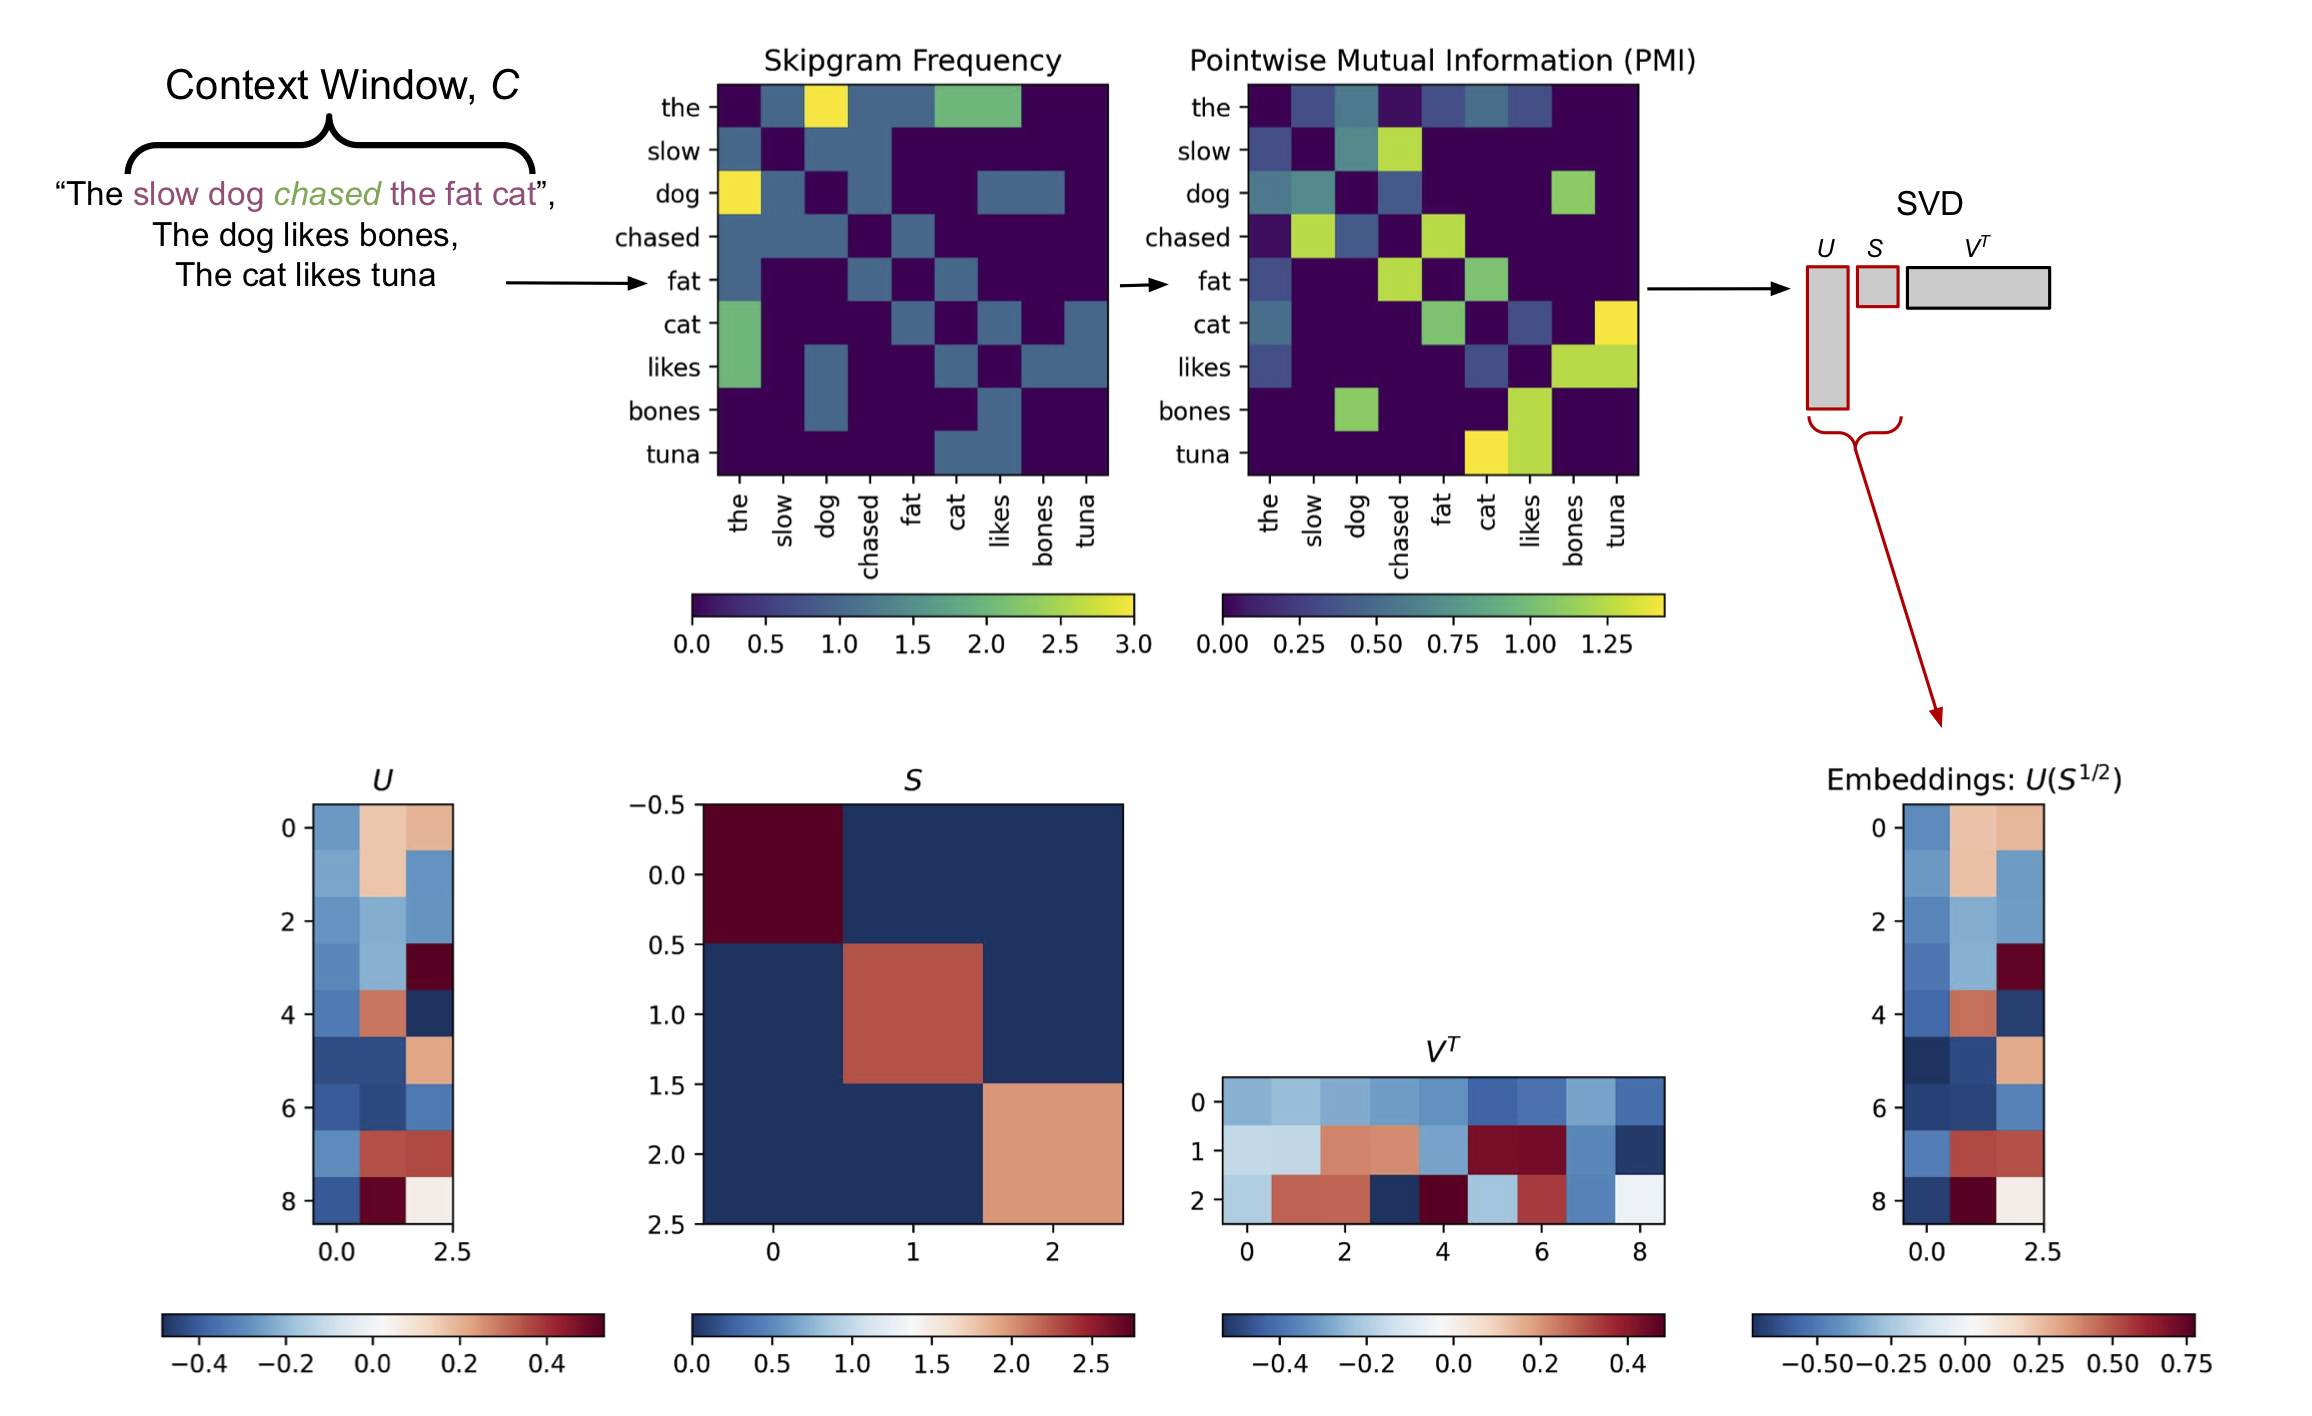

In [11]:
def SVD_word_embedding(matrix):
  """ Calcular word embedding del corpus mediante SVD
      Parametro: matrix =  Co-ocurrencia o PMI
      Return: Embedding por SVD para la matriz correspondiente
  """
  svd = TruncatedSVD(n_components=100, n_iter=50, algorithm='randomized')
  U = svd.fit_transform(matrix)

  return U * np.sqrt(svd.singular_values_)

In [12]:
word_embedding_svd_coo = SVD_word_embedding(matrix=Y_coo)
print('Word Embedding con SVD para la matriz de co-ocurrencia: ')
print(word_embedding_svd_coo)
print('Matriz de tamaño: ', word_embedding_svd_coo.shape)

Word Embedding con SVD para la matriz de co-ocurrencia: 
[[ 2.20628152 -0.05011614  2.14654372 ...  0.03622113 -0.05778203
   0.0534702 ]
 [ 2.58993316  1.0042436   1.14849039 ... -2.66807031 -1.56629308
   0.14255199]
 [ 1.14926503  0.47441223  1.3532328  ...  0.17949742 -0.35181953
  -0.04959016]
 ...
 [ 0.86527637  0.05472588 -0.11002873 ...  0.19217723  0.16749169
   0.12190187]
 [ 8.4286769   0.39833684  3.84373279 ...  0.08557358  0.38921746
   2.14107059]
 [ 3.72306519  0.59954635  0.89036551 ...  0.46874822  0.53879356
   0.0532668 ]]
Matriz de tamaño:  (1189, 100)


In [13]:
word_embedding_svd_pmi = SVD_word_embedding(matrix=Y_pmi)
print('Word Embedding con SVD para la matriz PMI: ')
print(word_embedding_svd_pmi)
print('Matriz de tamaño: ', word_embedding_svd_pmi.shape)

Word Embedding con SVD para la matriz PMI: 
[[ 1.89737915e+04 -7.62784001e-01  8.71918595e-01 ... -1.75987002e-02
   5.33606779e-03  2.60063793e-01]
 [ 1.90278735e+04 -2.58454131e+00  3.00407765e+00 ...  7.48746368e-01
  -8.71136823e-01  6.90608250e-01]
 [ 1.89770901e+04 -1.64075252e+00  4.07300061e+00 ... -6.50417261e-02
   3.13356731e-01 -1.79562786e-01]
 ...
 [ 1.89738534e+04 -2.27626937e+00 -3.90989350e-01 ...  1.13080333e-01
  -3.15445178e-01  2.76806020e-02]
 [ 1.90038860e+04  4.09970741e+00  4.12416375e+00 ... -7.99937938e-01
   9.24009630e-01 -1.52864980e+00]
 [ 1.89846457e+04 -7.81864075e-02  1.81060376e+00 ...  3.21737096e-01
   1.77864750e-01 -3.31967686e-02]]
Matriz de tamaño:  (1189, 100)


# **Análisis**

### **Similitud coseno**
La similitud coseno entre un vector embedding de Co-ocurrencia y PMI, para determinar la similitud entre dos vectores.

La similitud coseno se calcula utilizando el coseno del ángulo entre los dos vectores. El valor resultante varía entre -1 y 1, donde un valor de 1 indica una similitud máxima (vectores idénticos), 0 indica ninguna similitud (vectores ortogonales) y -1 indica similitud máxima en sentido opuesto (vectores opuestos).
$$Similaridad = cos(\theta) = \frac{A \cdot B}{\left \| A \right \|\left \| B \right \|}$$

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular la similitud del coseno entre los vectores
similarity = cosine_similarity(word_embedding_svd_coo[token_to_idx['herida']].reshape(1, -1), 
                               word_embedding_svd_pmi[token_to_idx['herida']].reshape(1, -1))

print('La similitud coseno entre las dos palabras es: ', similarity)

La similitud coseno entre las dos palabras es:  [[0.64974883]]


Similitud coseno entre dos vectores de la matriz de Co-ocurrencia y PMI, con el fin de comparar la similitud de la representación vectorial de la misma palabra.
Sabiendo que la similitud es de 0.6497, se puede inferir que hay cierta similitud en los dos embeddings, en termunos de su dirección y orientación en el espacio vectorial.

Sin embargo, es importante tener en cuenta que el valor de similitud coseno por sí solo no proporciona información detallada sobre las razones específicas detrás de esa similitud. La interpretación del valor depende del contexto y los datos con los que se haya construido la matriz de co-ocurrencia y la matriz PMI.

Ahora, se realiza la comparación de similitud entre dos palabras de la misma matriz, es decir, buscamos la relación semántica o análisamos de similitud entre palabras.

**Similitud coseno entre vectores de Co-ocurrencia**

In [15]:
similarity_coo = cosine_similarity(word_embedding_svd_coo[token_to_idx['vagina']].reshape(1, -1), 
                               word_embedding_svd_coo[token_to_idx['utero']].reshape(1, -1))

print('La similitud coseno entre las dos palabras es: ', similarity_coo)

La similitud coseno entre las dos palabras es:  [[0.50110969]]


Existe una similitud moderada entre ambas palabras en términos de su co-ocurrencia con otras palabras en el corpus utilizado.

Sin embargo, es importante tener en cuenta que el cálculo de la similitud coseno basado en la matriz de co-ocurrencia solo tiene en cuenta la frecuencia con la que las palabras aparecen juntas en el corpus. No tiene en cuenta otras propiedades semánticas o sintácticas de las palabras.

Por ejemplo, dado que "vagina" y "útero" están relacionadas anatómicamente y se mencionan con frecuencia en contextos relacionados con la salud reproductiva, es razonable que haya una cierta similitud en términos de su co-ocurrencia en el corpus utilizado.

**Similitud coseno entre vectores de PMI**

In [16]:
similarity_pmi = cosine_similarity(word_embedding_svd_pmi[token_to_idx['vagina']].reshape(1, -1), 
                               word_embedding_svd_pmi[token_to_idx['utero']].reshape(1, -1))

print('La similitud coseno entre las dos palabras es: ', similarity_pmi)

La similitud coseno entre las dos palabras es:  [[0.99999817]]


Este resultado nos está indicando que hay una igualdad o similitud alta entre los dos vectores de estas palabras en terminos de co-ocurrencia y relación de información mutua. Esto indica que las palabras tienen una alta similitud y una relación semántica fuerte en el contexto del corpus utilizado para construir la matriz PMI.

### **Analogías**

Aplicar aritmética vectorial al embedding de palabras para resolver tareas de analogía como "Rey es a la reina lo que hombre es a ___".

**Ejemplo:**

$$Embedding["king"] + Embedding["man"] = Embedding["queen"] + Embedding["woman"]$$


$$Embedding["queen"] = Embedding["king"] + Embedding["man"] - Embedding["woman"]$$

In [17]:
def analogias(w1, w2, w3):
  # Analogías y operaciones algebraicas
  analogia = word_embedding_svd_coo[token_to_idx[w1]] - word_embedding_svd_coo[token_to_idx[w2]] + word_embedding_svd_coo[token_to_idx[w3]]

  # Con el vector de analogía, recorro matriz de word embedding para ver que a que embedding es mas parecido
  vs_similaridad = []
  for i, array in enumerate(word_embedding_svd_coo):
    vs_similaridad.append(cosine_similarity(word_embedding_svd_coo[i].reshape(1, -1), analogia.reshape(1, -1))) #1000

  index_max = np.argmax(vs_similaridad)
  # Invertir el diccionario token_to_idx para obtener idx_to_token
  idx_to_token = {idx: token for token, idx in token_to_idx.items()}
  # Obtener la palabra correspondiente al índice del vector
  palabra = idx_to_token[index_max]

  print(f'Analogia: "{w1}" es a "{w2}", lo que "{palabra}" es a "{w3}"')

analogias('cesarea', 'parto', 'sangre')

Analogia: "cesarea" es a "parto", lo que "ablacion" es a "sangre"


Dado que los word embeddings capturan relaciones semánticas y asociaciones entre palabras, es posible que en un buen modelo de word embeddings, la analogía propuesta tenga sentido si existe una relación similar entre "cesárea" y "parto" como entre "ablación" y "sangre". Es decir, si en el contexto médico, la ablación está relacionada con la extracción o remoción de sangre de manera similar a cómo la cesárea está relacionada con el proceso de parto.

Sin embargo, es importante tener en cuenta que los word embeddings son representaciones estadísticas aprendidas a partir de datos y no siempre capturan todas las sutilezas y relaciones específicas de dominio. Por lo tanto, la validez de la analogía dependerá de la calidad y adecuación del modelo de word embeddings utilizado y de la coherencia de las relaciones en el dominio específico de la ginecología.

**Visualización del Embedding Space**

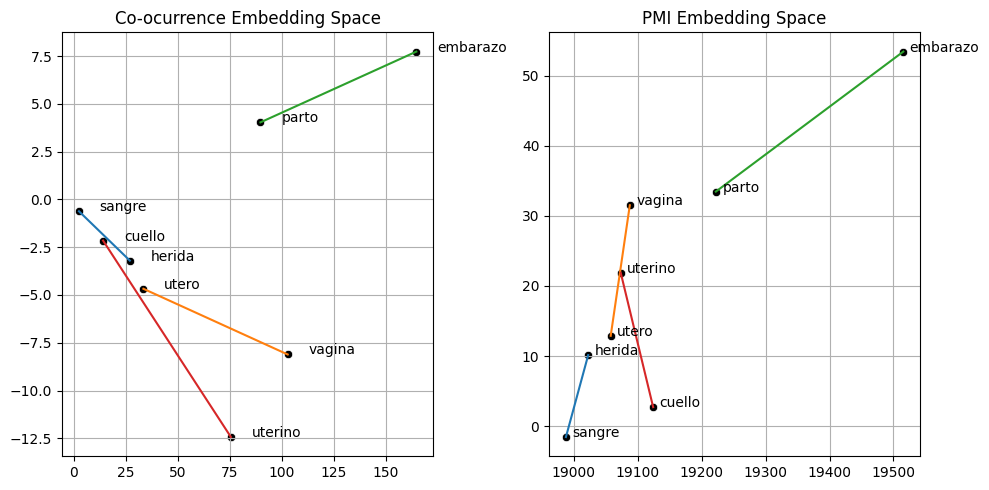

In [18]:
def plot_word_comparison(word_embedding, token_to_idx, word_pairs, name, ax):
    for pair in word_pairs:
        xys = []
        
        for label in pair:
            label_idx = token_to_idx[label]
            x = word_embedding[label_idx, 0]
            y = word_embedding[label_idx, 1]
            
            sns.scatterplot(x=[x], y=[y], color='black', ax=ax)
            ax.text(x + 10, y, label)
            xys.append([x, y])
        
        ax.plot([xys[0][0], xys[1][0]], [xys[0][1], xys[1][1]])
    
    ax.grid()
    ax.set_title(name)

# Crear el subplot con 2 columnas y 1 fila
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Palabras a comparar
word_pairs = [('sangre', 'herida'), ('utero', 'vagina'), ('embarazo', 'parto'), ('uterino', 'cuello')]

# Graficar la comparación utilizando el embedding basado en co-ocurrencia
plot_word_comparison(word_embedding_svd_coo, token_to_idx, word_pairs, 'Co-ocurrence Embedding Space', axs[0])

# Graficar la comparación utilizando el embedding basado en PMI
plot_word_comparison(word_embedding_svd_pmi, token_to_idx, word_pairs, 'PMI Embedding Space', axs[1])

plt.tight_layout()
plt.show()

Esta función es útil para visualizar y comparar las representaciones de palabras en diferentes espacios de embedding, lo que puede ayudar a comprender las relaciones semánticas y similitudes entre las palabras en un contexto específico.

**Representación de la dispersión de las palabras en el espacio vectorial**

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def gra_coo_pmi(word_embedding_svd_coo, word_embedding_svd_pmi):
    
    # Seleccionamos las palabras a graficar
    words_to_plot = ['desgarro', 'cesarea', 'cabeza', 'afebril', 'taquicardia', 'mamas', 'secretantes', 
                     'utero', 'sangrado', 'vagina', 'hematoma', 'hipertension', 'corazón', 'ecografia',
                     'leche', 'orina', 'fractura', 'mastitis', 'otitis', 'anemia', 'parto']
    # Etiquetas correspondientes a las palabras                     
    etiquetas = ['B-Signo o síntoma', 'I-Procedimiento', 'B-Anatomía', 'B-Signo o síntoma', 'B-Signo o síntoma', 'B-Anatomía', 'B-Signo o síntoma', 
                 'B-Anatomía', 'B-Signo o síntoma', 'B-Anatomía', 'B-Problema clínico', 'B-Signo o síntoma', 'B-Anatomía', 'B-Procedimiento',
                 'B-Sustancia', 'B-Sustancia', 'B-Problema clínico', 'B-Problema clínico', 'B-Problema clínico', 'B-Problema clínico', 'B-Procedimiento']
              

    # Crear un diccionario para mapear las etiquetas a colores
    label_colors = {
        'B-Signo o síntoma': 'blue',
        'B-Procedimiento': 'purple',
        'I-Procedimiento': 'green',
        'B-Anatomía': 'red',
        'B-Problema clínico': 'orange',
        'B-Sustancia': 'yellow'
    }

    # Obtenemos las coordenadas de las palabras en el espacio reducido
    coords_coo = [word_embedding_svd_coo[token_to_idx[word]] for word in words_to_plot]
    coords_pmi = [word_embedding_svd_pmi[token_to_idx[word]] for word in words_to_plot]

    # Creamos los subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Matriz de Co-ocurrencia', 'Matriz de PMI'])

    # Agregamos los scatter plots para la matriz de co-ocurrencia
    for word, coord, label in zip(words_to_plot, coords_coo, etiquetas):
        fig.add_trace(go.Scatter(
            x=[coord[0]],
            y=[coord[1]],
            mode='markers',
            marker=dict(color=label_colors[label]),
            name=word,
            hoverinfo='name',
            showlegend=False
        ), row=1, col=1)

    # Agregamos los scatter plots para la matriz de PMI
    for word, coord, label in zip(words_to_plot, coords_pmi, etiquetas):
        fig.add_trace(go.Scatter(
            x=[coord[0]],
            y=[coord[1]],
            mode='markers',
            marker=dict(color=label_colors[label]),
            name=word,
            hoverinfo='name',
            showlegend=False
        ), row=1, col=2)

    # Configuramos el diseño de los subplots
    fig.update_layout(
        title='Primeras dos dimensiones del embedding space',
        hovermode='closest'
    )

    # Agregamos el legend con las etiquetas
    for label, color in label_colors.items():
        fig.add_trace(go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(color=color),
            name=label,
            showlegend=True
        ))

    fig.show()

In [20]:
gra_coo_pmi(word_embedding_svd_coo, word_embedding_svd_pmi)

La similitud en la dispersión de los datos entre la matriz de co-ocurrencia y la matriz de PMI puede deberse a factores como el proceso de reducción de dimensionalidad utilizado (SVD), las características de las palabras seleccionadas para el gráfico y las características del espacio de embedding. El proceso de reducción de dimensionalidad puede haber mantenido la estructura y dispersión de los datos en ambos casos. Además, si las palabras seleccionadas tienen características semánticas o sintácticas similares, es probable que estén cercanas en el espacio de embedding y muestren una dispersión similar en el gráfico. También es posible que existan similitudes en las relaciones semánticas o sintácticas capturadas por ambas matrices, lo que resulta en una dispersión similar de los datos.

# **Conclusiones**
La matriz de co-ocurrencia y la PMI son enfoques complementarios en el análisis de texto. La matriz de co-ocurrencia brinda información sobre las frecuencias de co-ocurrencia, mientras que la PMI mide la asociación específica entre palabras, lo que ayuda a identificar patrones y relaciones semánticas.

El uso del SVD para ambas matrices tiene ventajas significativas. Reduce la dimensionalidad del espacio vectorial, lo que resulta en representaciones más compactas y eficientes. Además, el SVD puede capturar información semántica y sintáctica al descomponer la matriz en vectores latentes, lo que facilita tareas como la búsqueda de palabras similares.

Sin embargo, el SVD tiene limitaciones, ya que no considera el contexto más amplio en el que se utilizan las palabras, lo que puede afectar su capacidad para capturar matices y polisemia.

La transformación de los vectores singulares izquierdos mediante la raíz cuadrada de los valores singulares puede ser útil para ajustar la importancia de cada dimensión en la representación final de palabras, pero su aplicabilidad dependerá del contexto y de la tarea específica.

En cuanto al costo computacional, el cálculo de la PMI puede ser más costoso que el de la matriz de co-ocurrencia, ya que implica el cálculo de probabilidades conjuntas y marginales. Es importante evaluar el tiempo de ejecución y los recursos requeridos por cada técnica para generar los embeddings y considerarlos en función de las necesidades y restricciones computacionales.

# **Referencias**

[1] https://arxiv.org/pdf/1901.09069.pdf

[2] https://medium.com/analytics-vidhya/co-occurrence-matrix-singular-value-decomposition-svd-31b3d3deb305

[3] https://dustinstansbury.github.io/theclevermachine/info-theory-word-embeddings

[4] https://www.ida.liu.se/~TDDE09/commons/NLP-2021-12.pdf